# PCA, TSNE analysis of ephys features using AllenSDK

Import the neccessary data from the Allen institute. Using pandas dataframe present the electophysiology features.

In [1]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
import pandas as pd
import numpy as np
file = "/Users/noahjacobs/Triplab/Notebook/csv"

# Initialize the cache and dget the metadata for cells, download if neccessary (to current directory)
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')
cells = ctc.get_cells()

# Get the ephys features of all cells, download if neccessary
ephys_features = ctc.get_ephys_features()

ef_df = pd.DataFrame(ephys_features)

# List of all ephys feature names
ephys_features = list(ef_df)



Add labels: species, cre_line and dendrite_type to the dataframe to label each cell.

In [2]:
cell_index = {c['id']: c for c in cells}

# Label species, human (Homo Sapiens) or mouse (Mus musculus)
cell_types = [cell_index[cid]['species'] for cid in ef_df['specimen_id']]

ef_df['species'] = pd.Series(cell_types, index=ef_df.index)


# Label cre line
cell_index = {c['id']: c for c in cells}
cre_line = [cell_index[cid]['transgenic_line'] for cid in
                  ef_df['specimen_id']]

ef_df['cre_line'] = pd.Series(cre_line, index=ef_df.index)

# Set label cre line of human cells to 'Human'
for index, row in ef_df.iterrows():
    if "Homo Sapiens" in set(row):
        ef_df.set_value(index, 'cre_line', 'Human')

# Label dendrite type, spiny, aspiny, or sparsely spiny
dendrite_type = [cell_index[cid]['dendrite_type'] for cid in
                  ef_df['specimen_id']]

ef_df['dendrite_type'] = pd.Series(dendrite_type, index=ef_df.index)

#Drop cells without reporter_status = positive
dropped_cells = []
for x in cell_index:
    if cell_index[x]['species'] == 'Mus musculus':
        #print(cell_index[x]['reporter_status'])
        if cell_index[x]['reporter_status'] != 'positive':
            #dropped_cells++
            dropped_cells.append(x)
            
            
for x in dropped_cells:
    cell_index.pop(x)
print('{} cells dropped.'.format(len(dropped_cells)))




/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


105 cells dropped.


Find features with missing data and drop these features from the dataframe.

In [3]:
# Create a list of features that are to be dropped. Example: specimen id and data containing NaN
dropped_features = ['id', 'rheobase_sweep_id', 'rheobase_sweep_number',
                    'thumbnail_sweep_id', 'seal_gohm','vm_for_sag']
print()
# Find features with missing data
for index, column in ef_df.iteritems():
    na_array = pd.isna(column)
    for values in na_array:
        if values == True:
              if column.name not in dropped_features:
                    dropped_features.append(column.name)


dropped_features.sort()

# Drop the list of ephys features used for PCA.
for dropped_item in dropped_features:
    ephys_features.remove(dropped_item)
ephys_features.remove('specimen_id')

print('{} features dropped.'.format(len(dropped_features)))
print('{} features in dataframe.'.format(len(ephys_features)))

# Drop the features in the main dataframe.
ef_df.drop(columns=dropped_features, axis = 1, inplace = True)

print(dropped_features)
print(ephys_features)


25 features dropped.
30 features in dataframe.
['adaptation', 'avg_isi', 'electrode_0_pa', 'fast_trough_t_ramp', 'fast_trough_v_ramp', 'id', 'peak_t_ramp', 'peak_v_ramp', 'rheobase_sweep_id', 'rheobase_sweep_number', 'seal_gohm', 'slow_trough_t_long_square', 'slow_trough_t_ramp', 'slow_trough_t_short_square', 'slow_trough_v_long_square', 'slow_trough_v_ramp', 'slow_trough_v_short_square', 'threshold_i_ramp', 'threshold_t_ramp', 'threshold_v_ramp', 'thumbnail_sweep_id', 'trough_t_ramp', 'trough_v_ramp', 'upstroke_downstroke_ratio_ramp', 'vm_for_sag']
['f_i_curve_slope', 'fast_trough_t_long_square', 'fast_trough_t_short_square', 'fast_trough_v_long_square', 'fast_trough_v_short_square', 'has_burst', 'has_delay', 'has_pause', 'input_resistance_mohm', 'latency', 'peak_t_long_square', 'peak_t_short_square', 'peak_v_long_square', 'peak_v_short_square', 'ri', 'sag', 'tau', 'threshold_i_long_square', 'threshold_i_short_square', 'threshold_t_long_square', 'threshold_t_short_square', 'threshold

Create two more dataframe for mouse and human data.

In [4]:
# Mouse dataframe
mouse_ef_df = ef_df[ef_df['species']=='Mus musculus']
# Human dataframe
human_ef_df = ef_df[ef_df['species']=='Homo Sapiens']

print('Total number of human cells with electrophysiology features: {}'.format(len(human_ef_df)))
print('Number of human spiny cells: {}'.format(len(human_ef_df[human_ef_df['dendrite_type']=='spiny'])))
print('Number of human aspiny cells: {}'.format(len(human_ef_df[human_ef_df['dendrite_type']=='aspiny'])))
print('Number of human sparsely spiny cells: {}\n'.format(len(human_ef_df[human_ef_df['dendrite_type']=='sparsely spiny'])))

print('Total number of mouse cells with electrophysiology features: {}'.format(len(mouse_ef_df)))
print('Number of mouse spiny cells: {}'.format(len(mouse_ef_df[mouse_ef_df['dendrite_type']=='spiny'])))
print('Number of mouse aspiny cells: {}'.format(len(mouse_ef_df[mouse_ef_df['dendrite_type']=='aspiny'])))
print('Number of mouse sparsely spiny cells: {}'.format(len(mouse_ef_df[mouse_ef_df['dendrite_type']=='sparsely spiny'])))

Total number of human cells with electrophysiology features: 413
Number of human spiny cells: 321
Number of human aspiny cells: 79
Number of human sparsely spiny cells: 13

Total number of mouse cells with electrophysiology features: 1920
Number of mouse spiny cells: 892
Number of mouse aspiny cells: 921
Number of mouse sparsely spiny cells: 107


Import tools for principal component analysis from sklearn. Perform pricipal component analysis on ephys features without missing data.

In [5]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Separate out the features
x = ef_df.loc[:, ephys_features].values

# Standardize the features
x = StandardScaler().fit_transform(x)

# Perform a 2 component PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

# Overall PCA data
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

# Create a PCA dataframe with species, dendrite type, specimen id, cre line labels
finalDf = pd.concat([principalDf, ef_df[['species']]], axis = 1)
finalDf = pd.concat([finalDf, ef_df['dendrite_type']], axis = 1)
finalDf = pd.concat([finalDf, ef_df['specimen_id']], axis = 1)
finalDf = pd.concat([finalDf, ef_df[['cre_line']]], axis = 1)

Variance explained per principal component: [0.22321079 0.16085118]


/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Import seaborn and use it to graph the result of the PCA

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#Plot PCA graphs with two different visualization
plt.figure(figsize=(8, 8))
plt.title('2 Component PCA Colored by Species')
ax = sns.scatterplot(x="PC1", y="PC2", hue="species", style="dendrite_type", alpha=0.5, data=finalDf)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types")

plt.figure(figsize=(8, 8))
plt.title('2 Component PCA Colored by Dendrite Type')
ax = sns.scatterplot(x="PC1", y="PC2", hue="dendrite_type", style="species", alpha=0.5, data=finalDf)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types")

Perform a t-SNE analysis on the ephys features.

In [7]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(x)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2333 samples in 0.002s...
[t-SNE] Computed neighbors for 2333 samples in 0.319s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2333
[t-SNE] Computed conditional probabilities for sample 2000 / 2333
[t-SNE] Computed conditional probabilities for sample 2333 / 2333
[t-SNE] Mean sigma: 1.245149
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.714432
[t-SNE] KL divergence after 1000 iterations: 1.466959
t-SNE done! Time elapsed: 14.114755153656006 seconds


Create a dataframe for the t-SNE analysis to be plotted.

In [8]:
# Create a dataframe from the t-SNE results
tsneDf = pd.DataFrame(data = tsne_results, columns = ['x_tsne', 'y_tsne'])

# Create a t-SNE dataframe with species, dendrite type, specimen id, cre line labels
final_tsne_Df = pd.concat([tsneDf, ef_df[['species']]], axis = 1)
final_tsne_Df = pd.concat([final_tsne_Df, ef_df[['dendrite_type']]], axis = 1)
final_tsne_Df = pd.concat([final_tsne_Df, ef_df[['specimen_id']]], axis = 1)
final_tsne_Df = pd.concat([final_tsne_Df, ef_df[['cre_line']]], axis = 1)

Graph the t-SNE analysis by cell type.

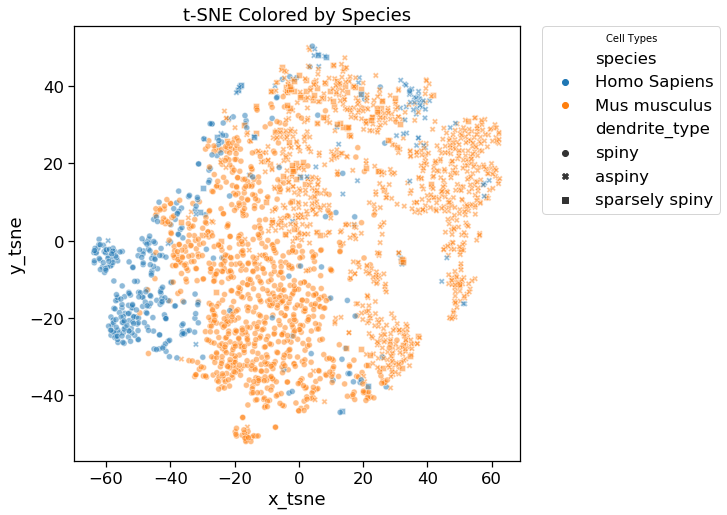

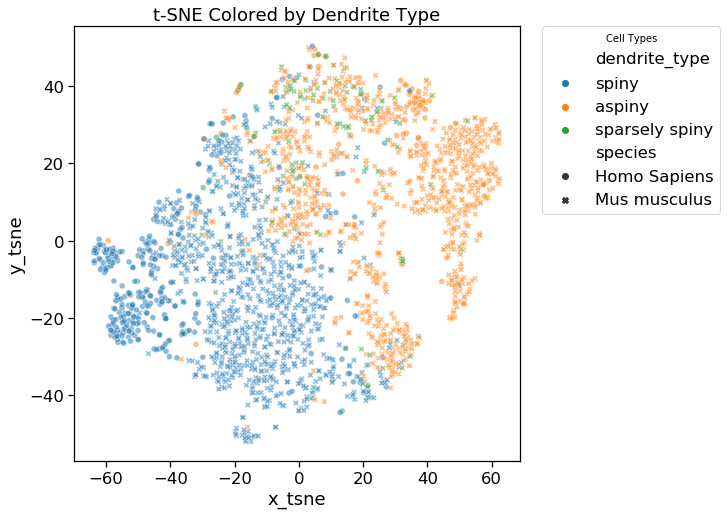

In [9]:
#Plot t-SNE graphs with two different visualization
plt.figure(figsize=(8, 8))
plt.title('t-SNE Colored by Species')
ax = sns.scatterplot(x="x_tsne", y="y_tsne", hue="species", style="dendrite_type",  alpha=0.5, data=final_tsne_Df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types")

plt.figure(figsize=(8, 8))
plt.title('t-SNE Colored by Dendrite Type')
ax = sns.scatterplot(x="x_tsne", y="y_tsne", hue="dendrite_type", style="species", alpha=0.5, data=final_tsne_Df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types")

From csv file driver_lines_anno, create color palette labels for cooresponding cre driver line of each cell. (Note: humans are labeled with black)

In [10]:
# Read the csv file from indicated path. Requires driver_line_anno.csv file
csv = pd.read_csv(file + "/driver_lines_anno.csv")

# Create cre_line color palette
cre_line_palette = {}
for index, row in csv.iterrows():
    cre_line_palette.update({row['driver_lines_label']:row['driver_lines_color']})

cre_line_palette.update({'Human':'#000000'})
cre_line_palette.update({'Mouse':'#FF0000'})
# Extraneous cre_line outside of file.
cre_line_palette.update({'Rorb-IRES2-Cre':'#2B8C88'})
cre_line_palette.update({'Esr2-IRES2-Cre-neo':'#5100FF'})
cre_line_palette.update({'Slc32a1-T2A-FlpO|Vipr2-IRES2-Cre':'#DF2166'})
cre_line_palette.update({'Vipr2-IRES2-Cre-neo':'#76958C'})
cre_line_palette.update({'Esr2-IRES2-Cre|PhiC31-neo':'#5100FF'})
cre_line_palette.update({'Esr2-IRES2-Cre-neo|PhiC31-neo':'#5100FF'})
cre_line_palette.update({'Pvalb-T2A-FlpO|Vipr2-IRES2-Cre':'#FF197F'})
cre_line_palette.update({'Pvalb-T2A-CreERT2':'#FF197F'})
cre_line_palette.update({'Nos1-CreERT2|Sst-IRES-FlpO':'#FFA500'}) #orange
cre_line_palette.update({'Chrna2-Cre_OE25|Pvalb-T2A-Dre':'#FF0000'}) #red
cre_line_palette.update({'Htr3a-Cre_NO152|Pvalb-T2A-Dre':'#C71585'}) #red purple

Generate t-SNE graph labeled by clusters of cre line and human cells using our predetermined color palette.

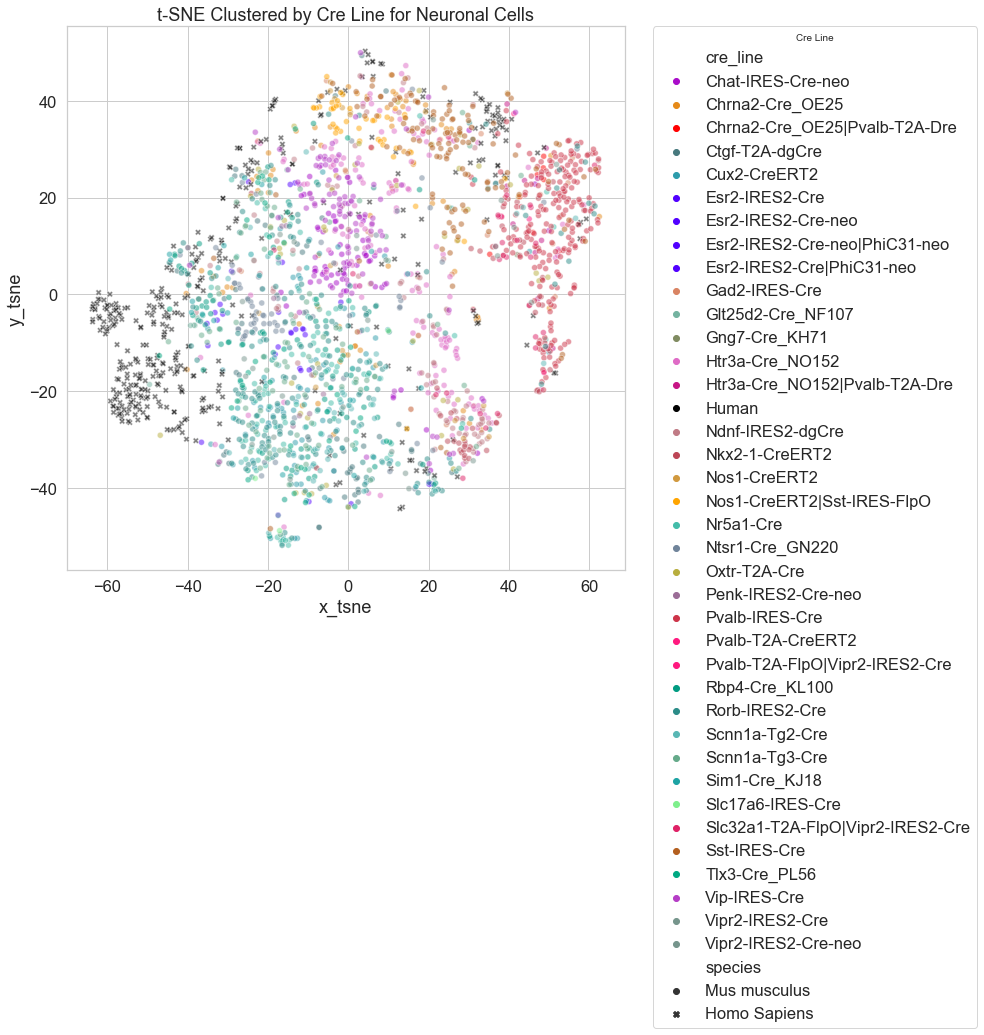

In [11]:
# Sort the t_SNE dataframe alphabetically by cre_line.
sorted_creline = final_tsne_Df.sort_values(by=['cre_line'])

sns.set_style("whitegrid")
plt.figure(figsize=(10, 10))
plt.title('t-SNE Clustered by Cre Line for Neuronal Cells')
ax = sns.scatterplot(x="x_tsne", y="y_tsne", hue="cre_line", style="species", 
                     alpha=0.5, data=sorted_creline, palette=cre_line_palette)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cre Line")

For each human cell, find the 5 nearest mouse cell neighbors within the t-SNE plot. Using the sklearn NearestNeighbors toolkit to find its 5 nearest mouse cell neighbors.

In [12]:
# Isolate only mouse cells to contain only t-SNE values and specimen id of each mouse cell
tsne_mouse = final_tsne_Df[final_tsne_Df['species'] == 'Mus musculus']
tsne_mouse = tsne_mouse.drop(['species', 'dendrite_type'], axis=1)

# Isolate only human cells to contain only t-SNE values and specimen id of each human cell
tsne_human = final_tsne_Df[final_tsne_Df['cre_line'] == 'Human']
tsne_human = tsne_human.drop(['species', 'dendrite_type'], axis=1)

In [13]:
from sklearn.neighbors import NearestNeighbors
## Instantiate the model with 5 neighbors. 
knn = NearestNeighbors(n_neighbors=5)

## Fit the model on the training data.
knn.fit(tsne_mouse.drop(['specimen_id', 'cre_line'], axis=1))

# The list of indices of the 5 closest neighbours for each human cell.
nearest = knn.kneighbors(tsne_human.drop(['specimen_id', 'cre_line'], axis=1), return_distance=False)

# Create a dictionary where the key is the index of the human cell, and the keys are the indices of 
# its five mouse neighbours.
five_nearest = {}
i = 0
for index, row in tsne_human.iterrows():
    five_nearest[int(index)] = nearest[i]
    i += 1

Create a dataframe that holds the information for the human cell and its five closest neighbors.

In [14]:
# Using nearest and five_nearest, create a dictionary holding specimen_id of the human cell as keys
# and its 5 mouse neighbor as values
sample_id_cluster = []
i=0
for keys in five_nearest.keys():
    sample_id_cluster.append([int(tsne_human.loc[keys]['specimen_id'])])
    for item in nearest[i]:
        sample_id_cluster[i].append(tsne_mouse.iloc[item]['specimen_id'])
    i += 1
    
sample_id_dict = {}
for id in sample_id_cluster:
    sample_id_dict[id[0]] = id[1:6]

# Create a similar dictionary holding specimen_id of the human cell as keys
# and the cre line of its 5 mouse neighbor as values
creline_cluster = []
i=0
for keys in five_nearest.keys():
    creline_cluster.append([int(tsne_human.loc[keys]['specimen_id'])])
    for item in nearest[i]:
        creline_cluster[i].append(tsne_mouse.iloc[item]['cre_line'])
    i += 1

creline_dict = {}
for id in creline_cluster:
    creline_dict[id[0]] = id[1:6]

# Concatanate the two dictionaries into one dataframe df_5_near holding the specimen id of the human cell
# and its 5 closest mouse neighbours' id and cre line.
data = []
for value in sample_id_dict.values():
    data.append(value)
    
i=0
for value in creline_dict.values():
    data[i].extend(value)
    i+=1

df_5_near = pd.DataFrame(data, index = sample_id_dict.keys(), columns= ['mouse_1', 'mouse_2','mouse_3', 
        'mouse_4', 'mouse_5', 'mouse_1_cre', 'mouse_2_cre', 'mouse_3_cre', 'mouse_4_cre', 'mouse_5_cre'])

# This will display the dataframe containing the specimen id of the human and its 5 mouse neighbors.
df_5_near

,mouse_1,mouse_2,mouse_3,mouse_4,mouse_5,mouse_1_cre,mouse_2_cre,mouse_3_cre,mouse_4_cre,mouse_5_cre
529878215,572609348,557874460,584682764,320880293,556363725,Glt25d2-Cre_NF107,Tlx3-Cre_PL56,Oxtr-T2A-Cre,Scnn1a-Tg3-Cre,Chrna2-Cre_OE25
548459652,572609348,557874460,320880293,556363725,584682764,Glt25d2-Cre_NF107,Tlx3-Cre_PL56,Scnn1a-Tg3-Cre,Chrna2-Cre_OE25,Oxtr-T2A-Cre
569095789,501799874,476263004,490259231,485938494,471819401,Ctgf-T2A-dgCre,Scnn1a-Tg3-Cre,Ntsr1-Cre_GN220,Ntsr1-Cre_GN220,Ntsr1-Cre_GN220
528706755,584682764,572609348,581394360,556363725,486262299,Oxtr-T2A-Cre,Glt25d2-Cre_NF107,Esr2-IRES2-Cre,Chrna2-Cre_OE25,Cux2-CreERT2
508279351,557874460,572609348,320880293,562999984,488689403,Tlx3-Cre_PL56,Glt25d2-Cre_NF107,Scnn1a-Tg3-Cre,Tlx3-Cre_PL56,Rorb-IRES2-Cre
643582610,481001895,555898896,569958754,567320213,569739534,Htr3a-Cre_NO152,Chrna2-Cre_OE25,Chrna2-Cre_OE25,Chrna2-Cre_OE25,Chrna2-Cre_OE25
530097064,557874460,320880293,572609348,556363725,488695444,Tlx3-Cre_PL56,Scnn1a-Tg3-Cre,Glt25d2-Cre_NF107,Chrna2-Cre_OE25,Rorb-IRES2-Cre
529909601,572609348,557874460,320880293,584682764,556363725,Glt25d2-Cre_NF107,Tlx3-Cre_PL56,Scnn1a-Tg3-Cre,Oxtr-T2A-Cre,Chrna2-Cre_OE25
569820026,501014504,490916882,328015342,569412397,564408650,Rbp4-Cre_KL100,Rbp4-Cre_KL100,Sst-IRES-Cre,Ndnf-IRES2-dgCre,Ndnf-IRES2-dgCre
542137330,580236419,513800575,515524026,569664731,584628220,Oxtr-T2A-Cre,Scnn1a-Tg3-Cre,Rbp4-Cre_KL100,Chrna2-Cre_OE25,Scnn1a-Tg3-Cre


To graph out each of the human cell and its 5 neighbours, we create a new dataframe to graph the 6 data points. 

In [15]:
cre_line_5 = ['Human']
x_tsne_5 = []
y_tsne_5 = []

# Specify the specimen id of the human cell
human_specimen = 528016025 #529878215 

# This will be the index that stores the human cell in the tsne_human list
number = (tsne_human[tsne_human['specimen_id']==human_specimen].index[0])

cre_line_5.append(df_5_near.loc[human_specimen]['mouse_1_cre'])
cre_line_5.append(df_5_near.loc[human_specimen]['mouse_2_cre'])
cre_line_5.append(df_5_near.loc[human_specimen]['mouse_3_cre'])
cre_line_5.append(df_5_near.loc[human_specimen]['mouse_4_cre'])
cre_line_5.append(df_5_near.loc[human_specimen]['mouse_5_cre'])

x_tsne_5.append((tsne_human[tsne_human['specimen_id']==human_specimen]).x_tsne)
for item in five_nearest[number]:
    x_tsne_5.append(tsne_mouse.iloc[item]['x_tsne'])

y_tsne_5.append((tsne_human[tsne_human['specimen_id']==human_specimen]).y_tsne)
for item in five_nearest[number]:
    y_tsne_5.append(tsne_mouse.iloc[item]['y_tsne'])



In [16]:
# This contains information about the creline, and the tSNE values of the human cell and its 5 neighbors
data_5 = {'cre_line':cre_line_5, 'x_tsne':x_tsne_5, 'y_tsne':y_tsne_5}
dataframe_5 = pd.DataFrame(data_5)


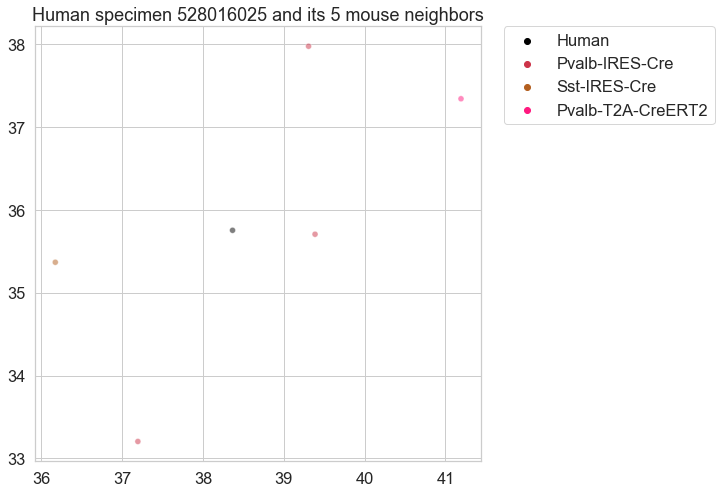

In [17]:
# Plot the human cell and its 5 nearest neighbors on the tSNE plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 8))
plt.title('Human specimen {} and its 5 mouse neighbors'.format(human_specimen))
ax = sns.scatterplot(x="x_tsne", y="y_tsne", hue="cre_line", alpha=0.5, data=data_5, palette=cre_line_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [18]:
averages = {}
for x in mouse_ef_df:
    if x == 'has_burst' or x == 'has_delay'or x == 'has_pause' or x == 'species' or x == 'cre_line' or x == 'dendrite_type' or x == 'specimen_id':
        print('Skipping ' + x)
    else:
        total = 0
        runs = 0
        for z in mouse_ef_df[x]:
            if type(z) is str:
                print(z)
            total = total + z
            runs = runs + 1
        averages[x] = total/runs

        

Skipping has_burst
Skipping has_delay
Skipping has_pause
Skipping specimen_id
Skipping species
Skipping cre_line
Skipping dendrite_type
